In [1]:
import transformers
import torch
import torch.nn as nn
from torch.utils import data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random
import ast
from others.config import *

hyperparameters = config['hyperparameters']
gpu = ('cuda:0')

In [2]:
dataset = pd.read_csv('dataset/Corona_NLP_train.csv')

In [3]:
dataset['label'] = dataset['Sentiment'].map({'Extremely Negative':0, 'Negative':1, 'Neutral':2, 'Positive':3, 'Extremely Positive':4})
dataset = dataset.rename(columns = {'OriginalTweet' : 'doc'})

In [4]:
dataset = dataset.iloc[:,4::2]

In [5]:
train, validation = train_test_split(dataset, test_size = 0.3, random_state = int(hyperparameters['RANDOM_STATE']))

In [6]:
len(validation)

12348

In [7]:
class CustomDataset(data.Dataset):
    def __init__(self, docs, labels, tokenizer, max_len):
        self.docs = docs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.docs)

    def __getitem__(self, item):
        docs = str(self.docs[item])
        labels = int(self.labels[item])
        encoded = tokenizer.encode_plus(
            docs,
            max_length = self.max_len,
            add_special_tokens = True,
            pad_to_max_length = True,
            return_attention_mask = True,
            truncation=True,
            return_tensors = 'pt'
        )
        return docs, labels, torch.squeeze(encoded['input_ids'], 0), torch.squeeze(encoded['attention_mask'], 0)

In [8]:
tokenizer = transformers.BertTokenizer.from_pretrained(hyperparameters['MODEL'])

In [9]:
validation_encoded = CustomDataset(validation.doc.to_numpy(), validation.label.to_numpy(), tokenizer, int(hyperparameters['MAX_LEN']))
validation_loader = data.DataLoader(validation_encoded, batch_size = ast.literal_eval(hyperparameters['BATCH_SIZES'])[1])

In [10]:
for docs, labels, input_ids, attention_mask in validation_loader:
    print('lables: {}, shape: {}'.format(labels, labels.shape))
    print('input_ids: {}, shape: {}'.format(input_ids, input_ids.shape))
    print('attention_mask: {}, shape: {}'.format(attention_mask, attention_mask.shape))
    break

lables: tensor([3, 0, 1, 3, 0, 1, 1, 4, 1, 4, 1, 1, 2, 4, 1, 3, 0, 1, 0, 4, 0, 2, 0, 2,
        3, 4, 4, 2, 1, 4, 1, 1, 0, 1, 3, 3, 4, 3, 1, 1, 1, 3, 2, 2, 3, 4, 3, 0,
        3, 2, 3, 2, 4, 1, 0, 2, 1, 2, 1, 0, 3, 1, 0, 4, 1, 0, 1, 0, 4, 4, 4, 1,
        4, 3, 2, 4, 1, 3, 1, 4, 0, 2, 1, 1, 1, 1, 3, 1, 3, 0, 1, 3, 3, 0, 4, 0,
        2, 3, 0, 1, 2, 3, 2, 2, 4, 3, 0, 3, 1, 2, 4, 1, 1, 2, 1, 1, 2, 0, 0, 4,
        4, 1, 4, 4, 0, 3, 0, 1]), shape: torch.Size([128])
input_ids: tensor([[  101, 15152,  1821,  ...,     0,     0,     0],
        [  101,   146, 26546,  ...,     0,     0,     0],
        [  101,  3291, 18312,  ...,     0,     0,     0],
        ...,
        [  101,  5360,  2182,  ...,     0,     0,     0],
        [  101,  1109,   108,  ...,  1132,  1136,   102],
        [  101,   108,  3291,  ...,   119,  1884,   102]]), shape: torch.Size([128, 64])
attention_mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,

In [11]:
class BERTModel(nn.Module):
    def __init__(self, n_output_classes):
        super(BERTModel, self).__init__()
        self.n_output_classes = n_output_classes
        self.bert = transformers.BertModel.from_pretrained(hyperparameters['MODEL'])
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(
            self.bert.config.hidden_size, 
            self.n_output_classes
            )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids,
            attention_mask
        )
        out = self.dropout(outputs[1])
        out = self.linear(out)
        return out

In [12]:
torch.manual_seed(int(hyperparameters['RANDOM_STATE']))
model = BERTModel(int(hyperparameters['NUM_OUTPUT_CLASSES'])).to(gpu)
checkpoint = torch.load('checkpoint/corona_tweets_lowest_val_loss_epoch_2.pth')
model.load_state_dict(checkpoint['state_dict'])
print(model)

BERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [13]:
test_preds = torch.tensor([])
for docs, labels, input_ids, attention_mask in validation_loader:
    model.eval()
    with torch.no_grad():
        preds = model(input_ids.to(gpu), attention_mask.to(gpu))
        preds = torch.max(preds, 1)
        test_preds = torch.cat(
            (test_preds, preds[1].cpu())
            )

test_act_labels =  torch.tensor([])
for docs, labels, input_ids, attention_mask in validation_loader:
    test_act_labels = torch.cat(
            (test_act_labels, labels)
            )

# print(test_preds)
# print(test_act_labels)

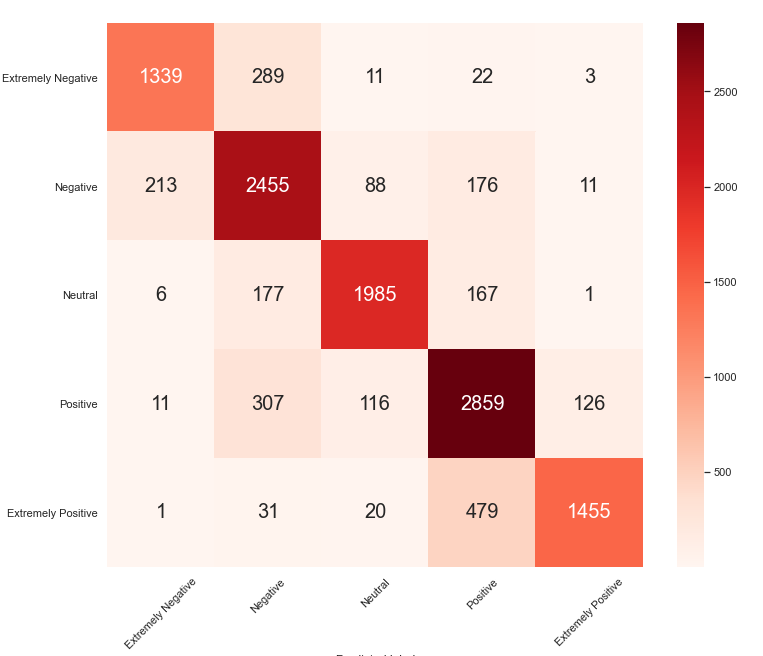

In [14]:
# confusion matrix
cnf_matrix = confusion_matrix(test_act_labels, test_preds)

# plot confusion matrix with seaborn
plt.figure(figsize=(12,10))

x_axis_labels = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
y_axis_labels = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']

sns.set(font_scale=1)#for label size
sns.heatmap(cnf_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, annot_kws={"size": 20} , cmap="Reds", fmt='g')

plt.yticks(rotation=360)
plt.xticks(rotation=45)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('graphs/cnf_bert.png', dpi = 100)

In [15]:
report = classification_report(test_act_labels, test_preds)
print(report)

              precision    recall  f1-score   support

         0.0       0.85      0.80      0.83      1664
         1.0       0.75      0.83      0.79      2943
         2.0       0.89      0.85      0.87      2336
         3.0       0.77      0.84      0.80      3419
         4.0       0.91      0.73      0.81      1986

    accuracy                           0.82     12348
   macro avg       0.84      0.81      0.82     12348
weighted avg       0.82      0.82      0.82     12348



In [16]:
# a single prediction
def inference(sentence):
    encoded = tokenizer.encode_plus(
            sentence,
            max_length = int(hyperparameters['MAX_LEN']),
            add_special_tokens = True,
            pad_to_max_length = True,
            return_attention_mask = True,
            truncation=True,
            return_tensors = 'pt'
        ).to(gpu)
    model.eval()
    with torch.no_grad():
        predictions = model(encoded['input_ids'].to(gpu), encoded['attention_mask'].to(gpu))
        prob = nn.functional.softmax(predictions, 1)
        max_prob, idx = torch.max(prob, 1)
        label = "Extremely Negative" if idx == 0 else ("Negative" if idx == 1 else ("Neutral" if idx == 2 else ("Positive" if idx == 3 else "Extremely Positive")))
    return print('Prediction : {} Sentiment\nThe Sentiment Probability is:\nExtremely Negative : {:.2f}%\nNegative : {:.2f}%\nNeutral : {:.2f}%\nPositive : {:.2f}%\nExtremely Positive : {:.2f}%'.format(label, prob[0][0].item()*100, prob[0][1].item()*100, prob[0][2].item()*100, prob[0][3].item()*100, prob[0][4].item()*100))

In [17]:
text = inference("My elderly in-laws are staying at home & I'm doing their shopping online. The old man married his TV a long time ago, so it's not a problem for him. The old dear just needs the phone & she's happy. Protect your loved ones, #Coronavi")
text

Prediction : Extremely Positive Sentiment
The Sentiment Probability is:
Extremely Negative : 0.15%
Negative : 0.03%
Neutral : 0.07%
Positive : 0.25%
Extremely Positive : 99.50%
